## Importing some stuff

In [4]:
import simpy
import random
import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [5]:
#Calculating moving average
def moving_average(numbers, window_size):
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1
    return moving_averages

In [6]:
def time_convert(time):
    time_max = 200
    time_min = -200 
    if time_min < time <= time_max:
        min_max_time = (time-time_min)/(time_max-time_min)
        scaled_time = min_max_time * 20 # Scaling time to be between 0 and 20
        return int(np.ceil(scaled_time))
    else:
        raise Exception("Input time value outside range in def time_convert")
    
    

In [7]:
time_convert(-199)

1

- f(`machine.queue`) => OpenAI State

In [8]:
tards = [25,30,34,0,0,0,-30]
mean_tard = np.mean(tards)
reward = - mean_tard
print(reward)

-8.428571428571429


In [9]:
import gym 

import itertools 

import matplotlib 

import matplotlib.style 

import numpy as np 

import pandas as pd 

import sys 

from collections import defaultdict 
import plotting 
import numpy as np
  

matplotlib.style.use('ggplot') 

### Flow shop environment

In [13]:
observation_space = gym.spaces.MultiDiscrete((3,3,3,3,21,21,21,21,3))

In [14]:
observation_space = gym.spaces.Tuple((gym.spaces.Discrete(3),gym.spaces.Discrete(3),
                                                  gym.spaces.Discrete(3),gym.spaces.Discrete(3),
                                                  gym.spaces.Discrete(21),gym.spaces.Discrete(21),
                                                  gym.spaces.Discrete(21),gym.spaces.Discrete(21),
                                                  gym.spaces.Discrete(3)))

In [26]:
class flowshopGym:
    import random
    # --------------------------------------INITIALIZE THINGS------------------------------------------
    def __init__(self):
        self.NUM_PRODUCTS = 200
        self.IAT = 0.001 # change this to sample from some distribution
        self.action_space = gym.spaces.Discrete(3)
        self.DEBUG = 1 # 1 = check simpy env ; 2 = check the openai processes
        self.tardiness_list = []
        self.time_list = []
        self.mean_tard = []
        #self.observation_space = gym.spaces.Discrete(9)
        # Rich observation space
        # Product type for the 4 product type, time left for the 4 products, product type in machine
        # For more details Thesis notes book on Notability
        self.observation_space = gym.spaces.Tuple((
                                                  gym.spaces.Discrete(3),gym.spaces.Discrete(3), # MC1 Queue prod type
                                                  gym.spaces.Discrete(3),gym.spaces.Discrete(3),
                                                  gym.spaces.Discrete(11),gym.spaces.Discrete(11), # MC1 Queue time left 
                                                  gym.spaces.Discrete(11),gym.spaces.Discrete(11),
                                                  gym.spaces.Discrete(3), # MC1 prod type
                                                  ))
        
        
        
        #self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        self.prod_and_requests = []
        self.machine_production = 0
        self.reward = 0 
        self.cumulative_reward = 0 
        self.machine1_prev_type = 0 # The previous product type in the machine
        self.QUEUE_LENGTH = 4
        self.DDF = 4
        self.metadata = []
        
        # The following two values from the setup time matrix
        self.P1_to_P2 = 10
        self.P2_to_P1 = 20
        
        # The range for the time converter
        self.TIME_MAX = 6000
        self.TIME_MIN = -6000
        
        self.state_format = 'Hosp'
    # --------------------------------------DEFINE PROCESSES------------------------------------------
    
    # Process 1 - Spawn of products
    def process_1(self):
        #print("Entered new product process")
        
        # Produce X number of products
        for i in range(self.NUM_PRODUCTS):
            
            # Creating instances of the product 
            ###print("creating instance", i)
            self.instances.append(self.product(self,self.envSimpy,'Product_%d' % i, self.store, self.machine))
            
            # IAT TIMEOUT BEFORE THE NEXT SPAWN
            #next_admission = random.expovariate(1 / interarrival_time)
            yield self.envSimpy.timeout(self.IAT)
        
        # After all the products are put into the store, start process 2
        # Process 2 - Getting products from the store and create machine request
        self.envSimpy.process(self.process_2())
    
    class product(object):
        def __init__(self, flowshopGym, envSimpy, name, number, machine):
            
            # Creating the required resources and environment
            self.envSimpy = envSimpy

            # State space variables
            self.prod_type = random.randint(1,2) # the product type of the product.
            self.production_time = 15
            
            
            # Rest of the variables
            
            # Using the method that Thomas said in rocketchat - TWK method
            # Formula is start time + sum of processing times * due date factor 
            # Due date factor is generally 3
            sim.TWK = self.envSimpy.now + self.production_time * sim.DDF # Total Work Content (TWK)
            self.production_due = sim.TWK
            #self.production_end = random.randint(np.ceil(self.envSimpy.now), np.ceil(TWK))
            self.name = name
            self.number = number
            self.machine = machine 
            
            ###print(self.name,"created")
            
            # putting the product into the store
            self.envSimpy.process(self.put_store())
            
 

        def put_store(self): # I am putting 
            yield sim.envSimpy.timeout(1)
            ###print("Putting the", self.name, "in the store at", self.envSimpy.now)
            yield sim.store.put(self)
            ###print("Items in the store",len(sim.store.items)," - time -",self.envSimpy.now)
            
        
    
    
    # -----------------------------PROCESS 2-------------------------------------------------  
    def process_2(self): # If machine.queue is less than 4, get a prod from store and create request
        while True:
            if len(self.machine.queue) < self.QUEUE_LENGTH:
                
                # Get product from store
                prod = yield self.store.get()
                
                TWK = self.envSimpy.now + prod.production_time * self.DDF # Total Work Content (TWK)
                prod.production_due = TWK
                # Request machine
                ###print("requesting machine for", prod.name)
                req = prod.machine.request()
                
                self.envSimpy.process(self.process_3(prod, req))
            else:
                yield self.envSimpy.timeout(1)
    
    def calc_setup_time(self, prod):
        #Setup process if required
        #returns the setup time

        #print("setup time ### ",self.machine1_prev_type , prod.prod_type, "at", self.envSimpy.now )
        if self.machine1_prev_type == 0:
            ###print("Previous machine type was 0")
            return 0 # dont' do anything during the first pass
        elif self.machine1_prev_type == prod.prod_type:
            ###print("Same product type between MC and incoming product")
            return 0 # Dont' do anything if the product types are the same 
        elif prod.prod_type == 2: # current product type = 2 meaning we have to do a changeover from 1 to 2
            ###self.reward = self.reward - 5 # -ve reward when there is a setup change
            return self.P1_to_P2
            ###print("Setup time prod1 to prod2 finished at",self.envSimpy.now )
        elif prod.prod_type == 1: # current product type = 1 meaning we have to do a changeover from 2 to 1
            ###self.reward = self.reward - 5 # -ve reward when there is a setup change
            return self.P2_to_P1
            ###print("Setup time prod2 to prod1 finished at",self.envSimpy.now )
        else:
            raise Exception("Sorry product type doesn't match available values [for Setup process]")
        
    # -----------------------------PROCESS 3-------------------------------------------------  
    def process_3(self,prod, req): # Wait for req to go through and then produce and release the machine  
        sim.prod_and_requests.append([prod,req])
        # Wait for the request to succeed
        yield req
        prod.production_start = sim.envSimpy.now
        # Fast Forwarding reward
        setup_time = self.calc_setup_time(prod)
        #production_start = self.envSimpy.now
        #projected_production_end = production_start + setup_time + prod.production_time
        #prod.tardiness = projected_production_end - prod.production_end # actual end time - deadline 
        #self.info['Tardiness'] = prod.tardiness
        #print("Prod start, setup, production_time, tardiness",production_start, setup_time, 
              #prod.production_time, prod.tardiness)
        
        # Decide the reward 
        #if prod.tardiness <= 0:
        #    sim.reward = sim.reward + 10 
        #else: 
        #    sim.reward = sim.reward + 0
        
                 
        yield self.envSimpy.timeout(setup_time)
        #print("Time after setup time", self.envSimpy.now)
        
        # ----------------------------
        ###print('Start production of ' + str(prod.name) + ' at '+ str(self.envSimpy.now)  )

        ###print("Production time", prod.production_time)
        self.machine_production = 1
        yield self.envSimpy.timeout(prod.production_time)
        prod.production_end = sim.envSimpy.now
        ###print('Production finished at' + str(self.envSimpy.now))
        
        
        
        
        # Changing the previous prod_type on the machine
        self.machine1_prev_type = prod.prod_type
        
         
            
        prod.tardiness = self.envSimpy.now - prod.production_due   # -ve is good; +ve is bad 
        
        self.info['Tardiness'] = prod.tardiness
        self.tardiness_list.append(prod.tardiness)
        self.mean_tard.append(np.mean(self.tardiness_list))

        # Reward function (works)
        if prod.tardiness <= 0: # 50 is the mean tardiness observed without any reward 
            sim.reward = sim.reward + 50
        else:
            pass
        
        
        # Reward function 1 --> Reward = - tardiness 
        #if prod.tardiness <= 0:
        #    sim.reward = sim.reward +  50#(-1 * prod.tardiness)
        #else:
        #    sim.reward = sim.reward + 0 
        
        # Reward function  
        #if prod.tardiness <= 0:
        #    sim.reward = sim.reward +  50#(-1 * prod.tardiness)
        #else:
        #    sim.reward = sim.reward  - 50         
        
        # Reward function 2 --> Reward = -(mean_tardiness[-1])
        #sim.reward = sim.reward + (mean_tard[-1])            
        
        #if prod.tardiness <= 0:
        #    sim.reward = sim.reward +  50#(-1 * prod.tardiness)
        #else:
        
        # Reward function
        #sim.reward = sim.reward + (-prod.tardiness)
        
        # Reward function
        #if prod.tardiness <= 0:
        #    sim.reward = sim.reward + (prod.tardiness)**2
        #else:
        #    sim.reward = sim.reward - (prod.tardiness)
        
        # Reward function
        #if prod.tardiness <= 50: # 50 is the mean tardiness observed without any reward 
        #    sim.reward = sim.reward + 50
        #else:
        #    sim.reward = sim.reward - 50
        
        # End of production 
        #print('End production of ' + str(prod.name) + ' at ' + str(self.envSimpy.now))


        # Wait for an acceptance only when there are products in the machine.queue
        if len(sim.machine.queue) != 0:
            self.machine_production = 0
            # 1. After production pass the time so that the agent can take action based on the latest state
            # 2. Pass time when the action chosen by the agent is rejection
            i = 0
            while True:
                if i == 0:
                    yield self.envSimpy.timeout(1)
                    #print("Timeout after production")
                i += 1

                
                ###print("Initial queue", sim.machine.queue)
                ###print("Initial queue LENGTH", len(sim.machine.queue))
                ###print("Current_action", sim.current_action)

                if sim.current_action == 1: #rejected

                    # rearrange the machine queue to reflect the rejection
                    sim.machine.queue.insert(len(sim.machine.queue), sim.machine.queue.pop(0))
                    ###print("Resultant queue",sim.machine.queue)
                    ###print("\n")
                    #print("Action rejected; Passing time by 1 ", i)
                    #print("Machine queue,prod types ", sim.machine.queue, sim.getObs())
                    #print("Current time " + str(self.envSimpy.now))
                    #print("Machine product type ",)
                    #print("Queue item 1 product type ", )
                    yield self.envSimpy.timeout(1)




                    # rearrange the machine queue to reflect the rejection
                    #self.machine.queue.insert(len(self.machine.queue), self.machine.queue.pop(0))


                    # print the rearranged machine queue
                    #print('#observation_after')
                    #print(envGym.getObservation())



                elif sim.current_action == 0: #if action accepted
                    ###print("Resultant queue",sim.machine.queue)
                    
                    ###print('\n')
                    break
                elif sim.current_action == 2: # do nothing action
                    #sim.reward = sim.reward - 5 
                    yield self.envSimpy.timeout(1)
        else:
            pass


        

        #print("Tardiness is ",prod.tardiness)
        # Production has ended now I have to take the next action using take_action()
        # envGym.machine.queue = envGym.take_action()
        #envGym.machine.queue = []

        # Release the machine
        #yield prod.machine.release(req)
        
        # Release the machine
        yield prod.machine.release(req)

        # timeout before the next check
        #yield env.timeout(1)
    # ----------------------------------------------------------------------------------------------
    # --------------------------------------DEFINE FUNCTIONS------------------------------------------
    # ----------------------------------------------------------------------------------------------
    
    def getObs(self): 
        # CREATING TUPLE/DICT TO HOLD INFO        
        test_state = dict()
        
        # Machine 1 product type - Initial value
        test_state['MC1_prod_type'] = 0
        # Machine 1 queue product type - Initial values
        test_state['MC1_queue1_type'] = 0
        test_state['MC1_queue2_type'] = 0
        test_state['MC1_queue3_type'] = 0
        test_state['MC1_queue4_type'] = 0 
        # Machine 1 queue time left - Initial values
        test_state['MC1_queue1_timeleft'] = 0
        test_state['MC1_queue2_timeleft'] = 0
        test_state['MC1_queue3_timeleft'] = 0
        test_state['MC1_queue4_timeleft'] = 0
        
        # 1. PRODUCT TYPE INSIDE THE MACHINE
        if len(sim.machine.users) != 0: #if the machine is not empty
            test_state['MC1_prod_type'] = (self.relater(sim.machine.users[0])).prod_type # Product type of the product inside machine 1
        else:
            pass # No product inside the machine
        if self.machine_production == 0: # if we enter the loop 
            test_state['MC1_prod_type'] = 0   
            
            
        # 2. PRODUCT TYPE IN MACHINE 1 QUEUE
        if len(sim.machine.queue) == 0: # queue is empty
            pass # Already defined these values while creating the dict()

        elif len(sim.machine.queue) == 1:
            # Machine 1 queue1 product type
            test_state['MC1_queue1_type'] = (self.relater(sim.machine.queue[0])).prod_type
            
        elif len(sim.machine.queue) == 2:
            # Machine 1 queue1 product type
            test_state['MC1_queue1_type'] = (self.relater(sim.machine.queue[0])).prod_type
            
            # Machine 1 queue2 product type
            test_state['MC1_queue2_type'] = (self.relater(sim.machine.queue[1])).prod_type
        
        elif len(sim.machine.queue) == 3:
            # Machine 1 queue1 product type
            test_state['MC1_queue1_type'] = (self.relater(sim.machine.queue[0])).prod_type
            
            # Machine 1 queue2 product type
            test_state['MC1_queue2_type'] = (self.relater(sim.machine.queue[1])).prod_type
            
            # Machine 1 queue3 product type
            test_state['MC1_queue3_type'] = (self.relater(sim.machine.queue[2])).prod_type
        
        elif len(sim.machine.queue) == 4:
            # Machine 1 queue1 product type
            test_state['MC1_queue1_type'] = (self.relater(sim.machine.queue[0])).prod_type
            
            # Machine 1 queue2 product type
            test_state['MC1_queue2_type'] = (self.relater(sim.machine.queue[1])).prod_type
            
            # Machine 1 queue3 product type
            test_state['MC1_queue3_type'] = (self.relater(sim.machine.queue[2])).prod_type
            
            # Machine 1 queue4 product type
            test_state['MC1_queue4_type'] = (self.relater(sim.machine.queue[3])).prod_type
        
        else:
            raise Exception("Queue length incompatible")

        
        # 3. TIME LEFT CALCULATION
        # for each position
        if test_state['MC1_queue1_type'] != 0: # product present
            time_left = self.time_left((self.relater(sim.machine.queue[0])).production_due)
            test_state['MC1_queue1_timeleft'] = self.time_convert(time_left)
                
        if test_state['MC1_queue2_type'] != 0: # product present
            time_left = self.time_left((self.relater(sim.machine.queue[1])).production_due)
            test_state['MC1_queue2_timeleft'] = self.time_convert(time_left)
        
        if test_state['MC1_queue3_type'] != 0: # product present
            time_left = self.time_left((self.relater(sim.machine.queue[2])).production_due)
            test_state['MC1_queue3_timeleft'] = self.time_convert(time_left)
        
        if test_state['MC1_queue4_type'] != 0: # product present
            time_left = self.time_left((self.relater(sim.machine.queue[3])).production_due)
            test_state['MC1_queue4_timeleft'] = self.time_convert(time_left)
            
        obs = [v for k,v in test_state.items()]    
        #print("------ obs ", tuple(obs))
        
        return tuple(obs)
    
    def time_left(self, due):
        #print("due, time now", due, sim.envSimpy.now)
        return (due - sim.envSimpy.now)
    
    def time_convert(self, time):
        #print("Time to convert",time)
        time_max = self.TIME_MAX
        time_min = self.TIME_MIN
        
        if self.TIME_MIN < time <= self.TIME_MAX:
            self.time_list.append(time)
            min_max_time = (time-time_min)/(time_max-time_min)
            scaled_time = min_max_time * 10 # Scaling time to be between 0 and 20
            return int(np.ceil(scaled_time))
        else:
            raise Exception("Input time value outside range in def time_convert")
    
     
    def encode(self, obs):
        #print('Entered encode')
        # (3), 3 [Machine queue type, machine product type]
        i = obs[0] 
        i *= 3
        
        i += obs[1]
        #print("Value of i inside encode ", i)
        return i
    
    def doneFn(self):
        # So the condition is, 
        #(no items in queue1 + queue2 + ...) AND 
        #(no machine is running)
        if self.machine.queue != None:
            lenQueue = len(self.machine.queue)
        else: 
            lenQueue = 0 
        lenMachinesUsed = self.machine.count
        #print("Queue length",lenQueue, "no machines used", lenMachinesUsed)
        # (self.relater(self.machine.queue[-1]).production_end)*2
        if (self.envSimpy.now) > self.TIME_MAX: # Early break if time crosses the TWK; Breaking 3 time steps early
            self.early_break = True
        else:
            self.early_break = False

        if (lenQueue == 0 and lenMachinesUsed == 0) or (self.early_break == True) :
            #print("length of queue ",lenQueue,"Machines used ", lenMachinesUsed)
            #print("###now, TWK", self.envSimpy.now, self.TWK)
            return True
        else:
            #print("length of queue ",lenQueue,"Machines used ", lenMachinesUsed)
            return False

    
    # A function to relate products and requests
    def relater(self,item):
        # Note that the input to this function shouldn't be a list. It should be of 
        # type request or product
        #print("Entered relater with this item ###", item, type(item))
        output_item = None
        
        if str(type(item)) != "<class '__main__.flowshopGym.product'>" and str(type(item)) != 'simpy.resources.resource.Request':
            raise Exception("Passed in a list to relater. Expecting request or product object")
            #print("Error passed in a list. Expecting request or product object")
            return None
        # If the input is a request
        #print("self.prod_and_requests", self.prod_and_requests)
        if type(item) == simpy.resources.resource.Request:
            for i, j in enumerate(self.prod_and_requests):
                if j[1] == item:
                    output_item = j[0]
                    return output_item
        else: #if the input is a product 
            for i, j in enumerate(self.prod_and_requests):
                if j[0] == item:
                    output_item = j[1]
                    return output_item   
    
    
    # --------------------------------------RENDER------------------------------------------
    
    
    
    
    # --------------------------------------RESET------------------------------------------
    def reset(self):
        #print("Entered Reset")
        # Initialise simpy environemnt and a machine
        self.envSimpy = simpy.Environment()
        self.machine = simpy.Resource(self.envSimpy,capacity = 1)
        self.store = simpy.Store(self.envSimpy) 
        
        # Initial variable definitions
        self.time_start = self.envSimpy.now
        self.next_time_stop = self.time_start + 1
        self.time_step = 1
        self.time_step_terminal = self.time_start + 100
        self.current_action = 0
        self.instances = []
         
        # Set up starting processes
        self.envSimpy.process(self.process_1())
        
        # Set starting state values

        
        # Inital load of patients (to average occupancy)
        #self._load_patients()
        
        # Starting values of observations
        observations = self.getObs()
        
        # Put state dictionary items into observations list (Define observations)
        #observations = [v for k,v in self.state.items()]
        return observations
    
    
    
    
    # --------------------------------------STEP------------------------------------------
    
    def step(self, action):
        
        # Define params
        self.current_action = action
        self.action_taken = False 
        self.info = {}
        sim.reward = 0 
        
        # Reward based on the production status
        #if self.machine_production == 1:  
        #    self.reward = -1 # a simple negative reward when the machine is waiting for a decision 
        #    if self.current_action == 0 or self.current_action == 1: # action is accepted or rejected
        #        self.reward = self.reward -20
        #        print("### wrong action")
        
        #print("machine is used by",sim.machine.users)
        #print("machine production status", self.machine_production)
        #print("Agent action", action)
        # Run for time_step
        self.next_time_stop += self.time_step
        self.envSimpy.run(until = self.next_time_stop)
        
        
        
        # Get values
        observation = self.getObs()
        done = self.doneFn()
        
        
        # each step has a -1 reward 
        #self.reward = self.reward - 1 
        

        
        if done == True and self.early_break != True:
            print(self.envSimpy.now)
            #self.reward = self.reward + 3000 # Very high reward for completing all jobs
        info = self.info
        self.cumulative_reward += self.reward
        #print("Values from Step",observation, sim.reward, done, info)
        # Return values
        return (observation, self.reward, done, info)

        
    

#### Random agent

In [11]:
sim = flowshopGym()
state = sim.reset()
epochs = 0
penalties, reward, epoch_reward = 0, 0, 0 
epsilon = 0.1
done = False
tardiness = []

while not done:
    
    # Random action
    action = sim.action_space.sample()
    
    # FIFO
    #action = 0
    
    
    #action = np.argmax(Q1[state])
    #if random.uniform(0, 1) < epsilon:
    #    action = sim.action_space.sample() # Explore action space
    #else:
    #    action = np.argmax(Q1[state]) # Exploit learned values
    ###print("###Taking an action at", sim.envSimpy.now)
    state, reward, done, info = sim.step(action)
    if reward == 0:
        penalties += 1
    try:
        tardiness.append(info['Tardiness'])
    except:
        pass
    
    epoch_reward += reward
    

    epochs += 1

    
mean_tardiness = sum(tardiness)/(len(tardiness))
print("End time is ", sim.envSimpy.now)
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))
print("Epoch reward ", epoch_reward)
print("Mean tardiness of epoch ", mean_tardiness, "(-ve is good)")
#print("Median")

4963
End time is  4963
Timesteps taken: 4962
Penalties incurred: 4894
Epoch reward  3400
Mean tardiness of epoch  30.221050000000073 (-ve is good)


#### Random - 51 epochs

In [47]:
from stable_baselines.common.vec_env import DummyVecEnv

In [24]:
%%time
sim = flowshopGym()
#sim = DummyVecEnv([lambda: sim]) # vectorization of the environment
#sim.reset()

"""Training the agent"""

import random
from IPython.display import clear_output


# For plotting metrics
all_epochs_random = []
all_penalties_random = []
all_rewards_random = []
all_tardiness_random = []

for i in range(1, 21):
    print(i)
    state = sim.reset()

    epochs, penalties, reward, episodic_reward, tardiness = 0, 0, 0, 0, []
    done = False
    
    while not done:
        action = 0
        #action = random.randint(0,2)
        next_state, reward, done, info = sim.step(action) 
        ###print("state, action", state, action)
        
        episodic_reward += reward
        
        if reward <= 0:
            penalties += 1
        
        state = next_state
        epochs += 1
        
        try:
            ###print(info['Tardiness'])
            tardiness.append(info['Tardiness'])
        except:
            pass

    all_epochs_random.append(i)
    all_penalties_random.append(penalties)
    all_rewards_random.append(episodic_reward)
    all_tardiness_random.append(np.mean(tardiness))
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

1
4731
2
4661
3
4641
4
4791
5
4701
6
4641
7
4651
8
4631
9
4701
10
4671
11
4611
12
4771
13
4521
14
4791
15
4581
16
4571
17
4621
18
4401
19
4671
20
4671
Training finished.

CPU times: user 3min 40s, sys: 1.77 s, total: 3min 42s
Wall time: 3min 51s


In [25]:
np.mean(all_tardiness_random[-20:]), np.mean(all_rewards_random[-20:])

(24.163550000000072, 1365.0)

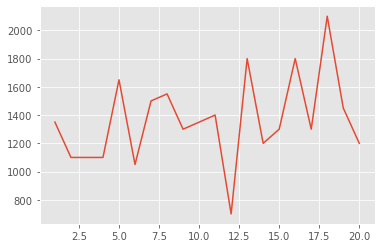

In [26]:
plt.plot(all_epochs_random[-20:],all_rewards_random[-20:])

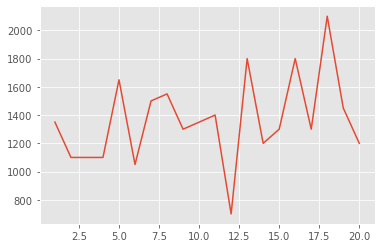

In [27]:
plt.plot(all_epochs_random,all_rewards_random)

### Overall flow - Q-learning - Taxi env

#### Q-learning


In [27]:
%%time
Q1 = defaultdict(lambda: np.zeros(sim.action_space.n)) 
sim = flowshopGym()
#sim.reset()

"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.3

# For plotting metrics
all_epochs = []
all_penalties = []
all_rewards = []
all_tardiness = []
all_steps = []

for i in range(1, 201):
    print(i)
    sim = flowshopGym()
    state = sim.reset()
    steps = []
    epochs, penalties, reward, episodic_reward, tardiness = 0, 0, 0, 0, []
    done = False
    episodic_reward_list = []
    step = 0
    while not done:
        step += 1
        
        if random.uniform(0, 1) < epsilon:
            action = sim.action_space.sample() # Explore action space
        else:
            action = np.argmax(Q1[state]) # Exploit learned values

        next_state, reward, done, info = sim.step(action) 
        ###print("state, action", state, action)
        old_value = Q1[state][action]
        next_max = np.max(Q1[next_state])
        
        new_value =  old_value + alpha * (reward + (gamma * next_max) - old_value)
        Q1[state][action] = new_value
        
        episodic_reward += reward
        episodic_reward_list.append(reward)
        
        if reward <= 0:
            penalties += 1
        
        state = next_state
        epochs += 1
        steps.append(step)
        try:
            #print(info['Tardiness'])
            tardiness.append(info['Tardiness'])
        except:
            pass
    
    all_steps.append(steps)
    all_epochs.append(i)
    all_penalties.append(penalties)
    all_rewards.append(episodic_reward)
    all_tardiness.append(np.mean(tardiness))
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 200
Training finished.

CPU times: user 6min 30s, sys: 12 s, total: 6min 42s
Wall time: 10min 32s


In [28]:
len(sim.tardiness_list)


200

Tardiness for each product in the last epoch

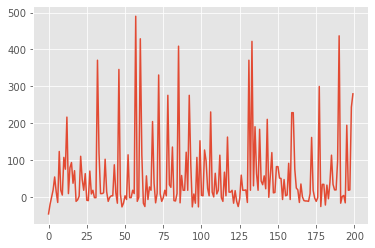

In [29]:
plt.plot(sim.tardiness_list)
plt.show()


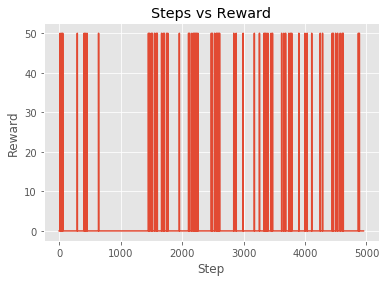

In [19]:
#For the last epoch
plt.plot(steps,episodic_reward_list)

plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Steps vs Reward")
plt.show()

In [20]:
np.mean(all_tardiness[-20:]),np.mean(all_rewards[-20:])

(29.370550000000073, 4177.5)

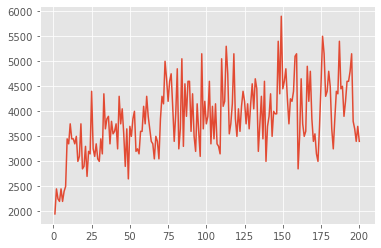

In [21]:
plt.plot(all_epochs,all_rewards)

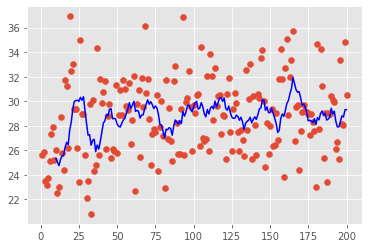

In [22]:
plt.scatter(all_epochs,all_tardiness)
plt.plot(all_epochs[9:],moving_average(all_tardiness, 10), color = 'blue')
plt.show()

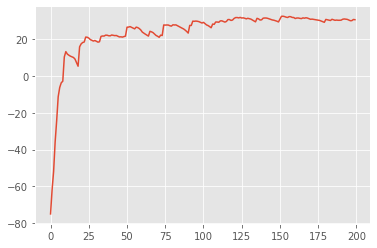

In [23]:
plt.plot(sim.mean_tard)
plt.show()

### System states

In [24]:
len(sim.tardiness_list)

200

In [25]:
for i in range(len(sim.prod_and_requests)):
    print(sim.prod_and_requests[i][0].production_start, sim.prod_and_requests[i][0].production_end, sim.prod_and_requests[i][0].production_due)

1 16 91
17 42 91.001
130 145 91.002
44 59 91.003
68 103 91.004
104 129 107.00399999999999
228 263 134.004
147 182 158.004
183 208 194.004
209 224 220.004
264 279 237.004
454 489 273.004
281 296 299.004
297 322 318.004
323 358 354.004
361 376 371.004
377 392 387.004
393 408 413.004
411 426 451.004
491 516 467.004
428 453 483.004
569 584 501.004
517 552 518.004
553 568 544.004
585 600 581.004
601 616 607.004
617 642 643.004
652 667 659.004
668 683 675.004
684 719 691.004
800 825 707.004
722 747 742.004
748 763 758.004
764 799 774.004
826 841 812.004
843 858 838.004
859 894 854.004
896 911 890.004
912 927 916.004
928 953 933.004
954 989 949.004
1239 1254 986.004
992 1017 1002.004
1018 1033 1018.004
1034 1069 1044.004
1071 1086 1082.004
1087 1112 1108.004
1113 1148 1124.004
1150 1175 1161.004
1176 1211 1177.004
1213 1238 1203.004
1255 1270 1240.004
1271 1306 1266.004
1367 1382 1303.004
1308 1333 1329.004
1334 1349 1345.004
1350 1365 1361.004
1814 1849 1398.004
1401 1436 1424.004
1598 1633 

### Comparing the Random agent and the Q learning agent

#### Mean Tardiness and Mean Rewards 

Random agent

In [150]:
np.mean(all_tardiness_random[-20:]),np.mean(all_rewards_random[-20:])

(54.988399390179055, 307.5)

Q learning agent

In [151]:
np.mean(all_tardiness[-20:]),np.mean(all_rewards[-20:])

(37.14930000000007, 50932.1023782499)

#### Tardiness

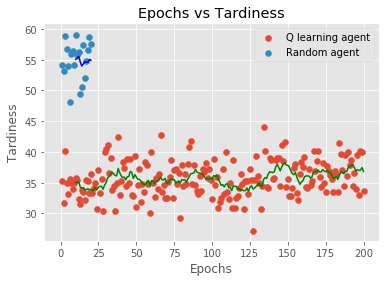

In [152]:
plt.scatter(all_epochs,all_tardiness, label = "Q learning agent")
plt.plot(all_epochs[9:],moving_average(all_tardiness,10), color = 'green')

plt.scatter(all_epochs_random,all_tardiness_random, label = "Random agent")
plt.plot(all_epochs_random[9:],moving_average(all_tardiness_random,10), color = 'blue')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Tardiness")
plt.title("Epochs vs Tardiness")
plt.show()

#### Rewards

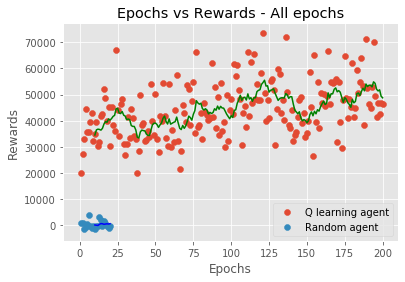

In [153]:
plt.scatter(all_epochs,all_rewards, label = "Q learning agent")
plt.plot(all_epochs[9:],moving_average(all_rewards,10), color = 'green')

plt.scatter(all_epochs_random,all_rewards_random, label = "Random agent")
plt.plot(all_epochs_random[9:],moving_average(all_rewards_random,10), color = 'blue')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.title("Epochs vs Rewards - All epochs")
plt.show()

In [154]:
len(Q1)

613

In [155]:
Q1

defaultdict(<function __main__.<lambda>()>,
            {(0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0): array([18.21280874, 40.59077932, 15.13321991]),
             (1,
              2,
              1,
              2,
              1,
              6,
              6,
              6,
              6): array([13.31737253, 14.26019492, 14.55378348]),
             (2,
              1,
              2,
              1,
              2,
              6,
              6,
              6,
              6): array([19.88763845, 14.89059062, 16.19333781]),
             (1,
              2,
              1,
              2,
              2,
              6,
              6,
              6,
              6): array([29.99545974, 29.38071793, 27.21262861]),
             (2,
              1,
              2,
              2,
              2,
              6,
              6,
              6,
            

### Exploitation of Q1


In [20]:
%%time
Q1 = defaultdict(lambda: np.zeros(sim.action_space.n)) 
sim = flowshopGym()
#sim.reset()

"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.3

# For plotting metrics
all_epochs = []
all_penalties = []
all_rewards = []
all_tardiness = []
all_steps = []

for i in range(1, 301):
    print(i)
    sim = flowshopGym()
    state = sim.reset()
    steps = []
    epochs, penalties, reward, episodic_reward, tardiness = 0, 0, 0, 0, []
    done = False
    episodic_reward_list = []
    step = 0
    while not done:
        step += 1
        
        action = np.argmax(Q1[state]) # Exploit learned values
        
        next_state, reward, done, info = sim.step(action) 
        
        
        episodic_reward += reward
        episodic_reward_list.append(reward)
        
        if reward <= 0:
            penalties += 1
        
        state = next_state
        epochs += 1
        steps.append(step)
        try:
            #print(info['Tardiness'])
            tardiness.append(info['Tardiness'])
        except:
            pass
    
    all_steps.append(steps)
    all_epochs.append(i)
    all_penalties.append(penalties)
    all_rewards.append(episodic_reward)
    all_tardiness.append(np.mean(tardiness))
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 300
Training finished.

CPU times: user 4min 58s, sys: 8.59 s, total: 5min 7s
Wall time: 5min 1s


In [21]:
np.mean(all_tardiness[-20:]),np.mean(all_rewards[-20:])

(25.62355000000007, 1252.5)

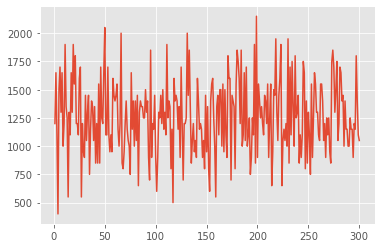

In [22]:
plt.plot(all_epochs,all_rewards)

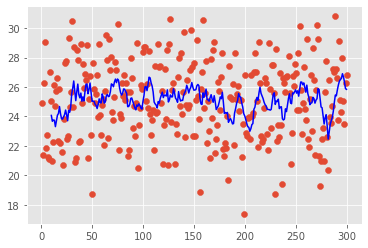

In [23]:
plt.scatter(all_epochs,all_tardiness)
plt.plot(all_epochs[9:],moving_average(all_tardiness, 10), color = 'blue')
plt.show()